# Illustrate scaling behaviour of filter inference

In [34]:
import os

import arviz as az
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

## Import results

In [66]:
# Import scaling results with number of snapshot measurements
directory = os.path.dirname(os.getcwd())
cancer_data = pd.read_csv(directory + '/1_cancer_growth/scaling_with_measurements.csv')

directory = os.getcwd()
egf_data = pd.read_csv(directory + '/scaling_with_measurements.csv')

## Visualise scaling with number of measurements

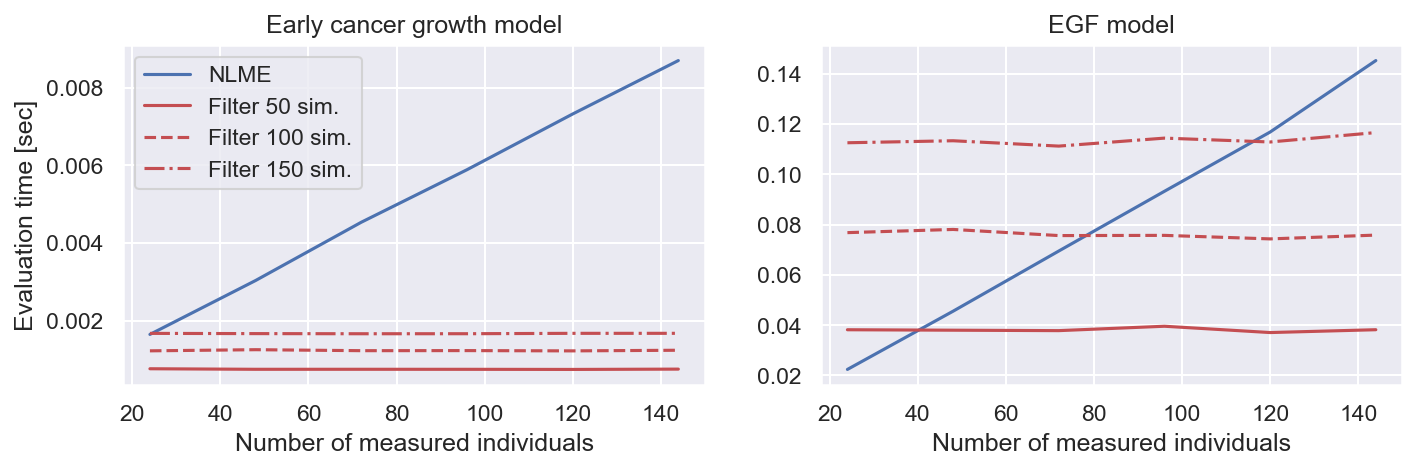

In [69]:
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes[0].sharex(axes[1])

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot scaling behaviour
# Cancer growth model
mask = cancer_data.Type == 'NLME'
n_ids = cancer_data[mask]['Number of measured individuals']
axes[0].plot(n_ids, cancer_data[mask]['Cost in sec'], label='NLME')
mask = cancer_data.Type == 'Filter 50'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 50 sim.',
    color=sns.color_palette()[3], linestyle='solid')
mask = cancer_data.Type == 'Filter 100'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 100 sim.',
    color=sns.color_palette()[3], linestyle='--')
mask = cancer_data.Type == 'Filter 150'
axes[0].plot(
    n_ids, cancer_data[mask]['Cost in sec'],
    label='Filter 150 sim.',
    color=sns.color_palette()[3], linestyle='-.')

# EGF model
mask = egf_data.Type == 'NLME'
n_ids = egf_data[mask]['Number of measured individuals']
axes[1].plot(n_ids, egf_data[mask]['Cost in sec'], label='NLME')
mask = egf_data.Type == 'Filter 50'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 50 sim.',
    color=sns.color_palette()[3], linestyle='solid')
mask = egf_data.Type == 'Filter 100'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 100 sim.',
    color=sns.color_palette()[3], linestyle='--')
mask = egf_data.Type == 'Filter 150'
axes[1].plot(
    n_ids, egf_data[mask]['Cost in sec'],
    label='Filter 150 sim.',
    color=sns.color_palette()[3], linestyle='-.')

# Labelling
axes[0].set_xlabel('Number of measured individuals')
axes[0].set_ylabel('Evaluation time [sec]')
axes[1].set_xlabel('Number of measured individuals')
axes[1].set_ylabel('')
axes[1].set_title('EGF model')
axes[0].set_title('Early cancer growth model')
axes[0].legend()

directory = os.getcwd()
plt.savefig(
    directory + '/01_scaling_with_measurements.tif',
    bbox_inches='tight')
plt.savefig(
    directory + '/01_scaling_with_measurements.pdf',
    bbox_inches='tight')

plt.show()

## Illustrate effective sample size after warm up

In [47]:
# Import Cancer modelling results
directory = os.path.dirname(os.getcwd())
cancer_results = xr.load_dataset(
    directory +
    '/1_cancer_growth/posteriors/8_filter_inference_cancer_growth_100_ids.nc')

# Import EGF results
directory = os.getcwd()
egf_results = xr.load_dataset(
    directory + '/posteriors/filter_inference_egf_pathway.nc')

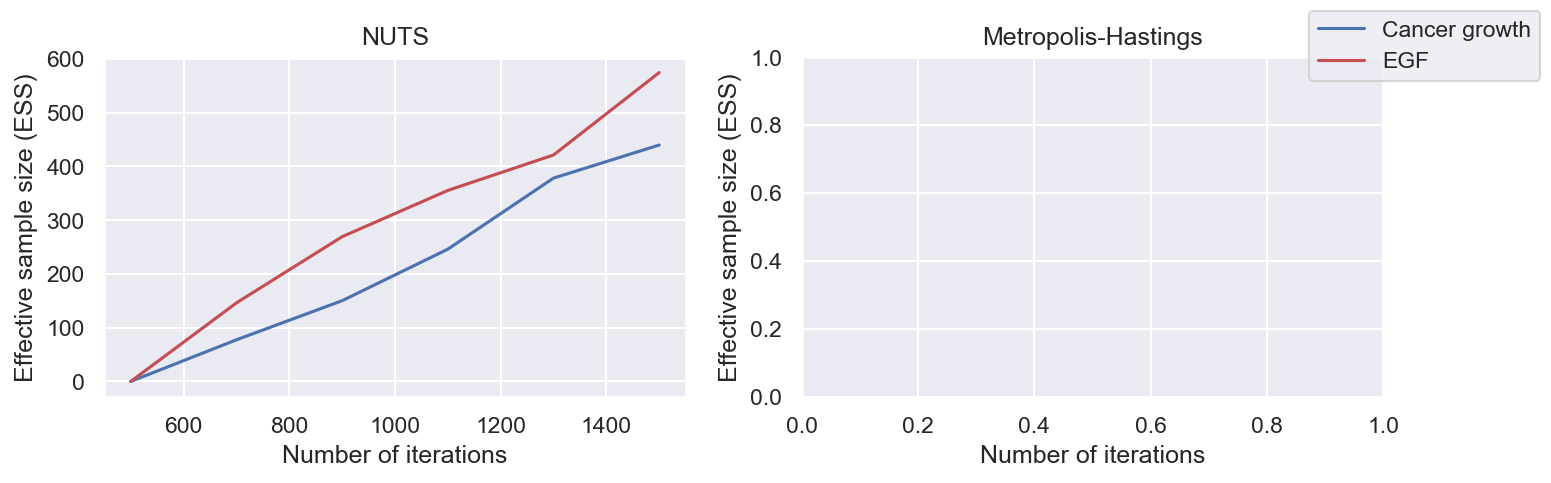

In [54]:
# Visualise
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 600 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axis for data
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot scaling behaviour
# Compute ESS of EGF inference using NUTS
parameters = [
    'Mean Initial count',
    'Mean Growth rate',
    'Std. Initial count',
    'Std. Growth rate',
    'Sigma Count']
n_iterations = [500, 700, 900, 1100, 1300, 1500]
mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(cancer_results[parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(n_iterations, mean, label='Cancer growth')

# Compute ESS of EGF inference using NUTS
parameters = [
    'Mean myokit.activation_rate',
    'Std. myokit.activation_rate',
    'Pooled myokit.deactivation_rate',
    'Pooled myokit.degradation_rate_active_receptor',
    'Pooled myokit.degradation_rate_inactive_receptor',
    'Mean myokit.production_rate',
    'Std. myokit.production_rate']
n_iterations = [500, 700, 900, 1100, 1300, 1500]
mean = []
for n in n_iterations:
    if n == 500:
        mean += [0]
        continue

    ess = az.ess(egf_results[parameters].sel(draw=slice(500, n)))
    m = np.min([ess[p].values for p in parameters])
    mean += [m]
axes[0].plot(n_iterations, mean, label='EGF', color=sns.color_palette()[3])

# Labelling
axes[0].set_xlabel('Number of iterations')
axes[0].set_ylabel('Effective sample size (ESS)')
axes[0].set_title('NUTS')
axes[1].set_xlabel('Number of iterations')
axes[1].set_ylabel('Effective sample size (ESS)')
axes[1].set_title('Metropolis-Hastings')
fig.legend()

plt.show()